In [62]:
# Setting up
from __future__ import print_function, division
import os
import numpy as np
import torch
import pandas as pd
from skimage import io, transform

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from training_utils import *
from data_loading import *


#transform_list = transforms.Compose([grey_world(),transforms.ToPILImage(),transforms.Scale(250),transforms.RandomHorizontalFlip() ,
#                                     transforms.RandomCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
#without color constancy 
transform_list = transforms.Compose([transforms.ToPILImage(),transforms.Scale(224),transforms.RandomCrop(224),
                                     transforms.ToTensor()])#, transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


# transforms.RandomRotation(90, expand=True) and VerticalFlip() not working for some reason!!
input_dir= '../datasets/'
#input_dir = '/mnt/nfs/work1/lspector/aks/datasets/'

useSegmentation=False

train = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Training_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Training_Data/',segment_dir=input_dir+'ISIC-2017_Training_Part1_GroundTruth',useSegmentation = useSegmentation, transform=transform_list)
train_light = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Training_Part3_GroundTruth_light.csv',
                                    root_dir=input_dir+'ISIC-2017_Training_Data/',segment_dir=input_dir+'ISIC-2017_Training_Part1_GroundTruth',useSegmentation = useSegmentation, transform=transform_list)


validation  = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Validation_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Validation_Data/',segment_dir=input_dir+'ISIC-2017_Validation_Part1_GroundTruth', useSegmentation =useSegmentation,transform = transform_list)
test = SkinLesionDataset(csv_file=input_dir+'ISIC-2017_Test_v2_Part3_GroundTruth.csv',
                                    root_dir=input_dir+'ISIC-2017_Test_v2_Data/',segment_dir=input_dir+'ISIC-2017_Test_v2_Part1_GroundTruth', useSegmentation =useSegmentation,transform = transform_list)

train_data = DataLoader(train, batch_size=8,
                        shuffle=True, num_workers=1)
train_data_light = DataLoader(train_light, batch_size=8,
                        shuffle=True, num_workers=1)
val_data = DataLoader(validation, batch_size=8,
                        shuffle=True, num_workers=1)
test_data = DataLoader(test, batch_size=8,
                        shuffle=True, num_workers=1)

dataset_sizes = {'train':len(train),'val':len(validation),'test':len(test)}
print(dataset_sizes)

dataloaders = {'train':train_data,'val':val_data,'test':test_data}
%load_ext autoreload
%autoreload 2

{'test': 600, 'train': 2000, 'val': 150}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print(train_data[0:2])

TypeError: 'DataLoader' object has no attribute '__getitem__'

In [119]:
def masking(img, img_segment, level_of_opaqueness):
    #level_of_opaqueness: the more it it, the more opaque the object becomes, values between (0,255)
    img_modified = img
    img_modified[img_segment==0] =level_of_opaqueness
    return img_modified

(767, 1022, 3) (767, 1022)


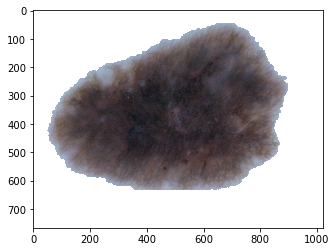

In [120]:
from skimage import io, transform
#np.set_printoptions(threshold='nan')
image1 = io.imread('../datasets/ISIC-2017_Training_Data/ISIC_0000000.jpg')
image2 = io.imread('../datasets/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png')
#image_modified = grey_world(image)

#print(image2)

#image2 = np.ones(image2.shape)

print(image1.shape, image2.shape)
image_modified = masking(image1, image2,255)
plt.imshow(image_modified)
#plt.imshow(image)

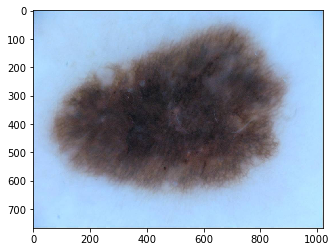

In [15]:
plt.imshow(image1)

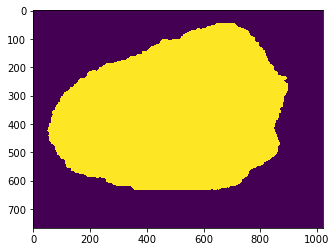

In [16]:
plt.imshow(image2)

0 8
1 8
2 8


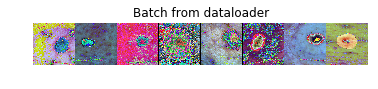

In [113]:
for i_batch, sample_batched in enumerate(test_data):
    print(i_batch, sample_batched['image'].shape[0])

    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

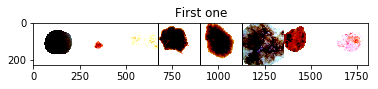

In [124]:
# visualizing some images
# Get a batch of training data
inputs = next(iter(train_data))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out, title="First one")

In [27]:
model_resnet = torchvision.models.resnet34(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features

#print(num_ftrs)
model_resnet.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=1.13e-03, weight_decay = 5.37e-04, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [61]:
print(1.13e-03)

0.00113


In [3]:
model_vgg = torchvision.models.vgg19_bn(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_vgg.classifier[6].out_features#model_vgg.fc.in_features

#print(num_ftrs)
model_vgg.classifier.add_module("7",nn.ReLU())
model_vgg.classifier.add_module("8",nn.Linear(num_ftrs, 2))
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_vgg.classifier[8].parameters(), lr=0.001, weight_decay = 5.37e-04, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [60]:
#Hyper-parameter tuning
from numpy.random import uniform

dataset_sizes1 = {'train':len(train_light),'val':len(validation),'test':len(test)}
print(dataset_sizes1)

dataloaders1 = {'train':train_data_light,'val':val_data,'test':test_data}

#for Resnet
maxcount = 10
for count in range(maxcount):
    reg = 10**uniform(-5, 0)
    lr = 10**uniform(-3,-5)
    optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=lr, weight_decay = reg, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    model_conv = train_model(model_resnet, criterion, optimizer_conv,
                         exp_lr_scheduler, dataloaders1,dataset_sizes1,num_epochs=2)
    print("reg: %.4e" %reg)
    print("lr: %.4e" %lr)
    print("--------------")
    print("")


{'test': 600, 'train': 1000, 'val': 150}
Epoch 0/1
----------
train Loss: 0.0624 Acc: 0.7980 AUC: 0.5153
val Loss: 0.0561 Acc: 0.8333 AUC: 0.5257

Epoch 1/1
----------
train Loss: 0.0577 Acc: 0.8030 AUC: 0.5497
val Loss: 0.0588 Acc: 0.8133 AUC: 0.5492

Training complete in 11m 59s
Best val Acc: 0.833333
reg: 1.1359e-03
lr: 5.3748e-04
--------------

Epoch 0/1
----------
train Loss: 0.0530 Acc: 0.8100 AUC: 0.5853
val Loss: 0.0604 Acc: 0.8133 AUC: 0.5786

Epoch 1/1
----------
train Loss: 0.0507 Acc: 0.8210 AUC: 0.6013
val Loss: 0.0604 Acc: 0.8000 AUC: 0.5979

Training complete in 12m 53s
Best val Acc: 0.813333
reg: 6.5358e-04
lr: 3.1171e-04
--------------

Epoch 0/1
----------
train Loss: 0.0565 Acc: 0.8120 AUC: 0.6122
val Loss: 0.0581 Acc: 0.7933 AUC: 0.6069

Epoch 1/1
----------
train Loss: 0.0540 Acc: 0.8270 AUC: 0.6363
val Loss: 0.0613 Acc: 0.8067 AUC: 0.6322

Training complete in 13m 5s
Best val Acc: 0.806667
reg: 5.2831e-03
lr: 9.8781e-04
--------------

Epoch 0/1
----------
train 

In [ ]:
dataset_sizes1 = {'train':len(validation),'val':len(validation),'test':len(test)}
#print(dataset_sizes1)

dataloaders1 = {'train':val_data,'val':val_data,'test':test_data}

model_conv = train_model(model_resnet, criterion, optimizer_conv,
                         exp_lr_scheduler, dataloaders1,dataset_sizes1,num_epochs=1)


Epoch 0/0
----------


In [164]:
inputs = next(iter(test_data))

#mymodel  = model_resnet
#mymodel.load_state_dict(torch.load(models_dir+'110.pt'))
#mymodel.load_state_dict(model_state_list[0])
#mymodel =  torch.load(torch.load(models_dir+'110.pt'))
outputs  = model_conv(Variable(inputs['image']))
print(outputs)

Variable containing:
 0.0046  0.2915
 0.3856  0.4468
 0.2292  0.3051
 0.4713  0.0797
 0.3642 -0.2360
 0.6349  0.5771
 0.0959 -0.1997
 0.7666  0.6493
[torch.FloatTensor of size 8x2]



In [129]:
#test_model(model_conv, criterion, dataloaders1,dataset_sizes1)

Process Process-9:
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
Traceback (most recent call last):
  File "/Users/aksaini/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/aksaini/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "data_loading.py", line 63, in __getitem__
    img_name = os.path.join(self.root_dir, self.classification_frame.ix[idx, 0]+'.jpg')
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/skimage/io/_io.py", line 61, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages/skimage/io/manage_plugins.py", line 211, in call_plugin
    return func(*args, **kwargs)
  File "/Users/aksaini/anaconda/lib/python2.7/site-packages

KeyboardInterrupt: 

In [5]:
print("Results using ensamble learning")

models_dir = '../models/'
#models_dir = input_dir
model_state_list = None
num_epochs = 5
model= model_resnet#, model_vgg
model_num = 1 # 1 for resnet
#models_list = train_model_epochs(model, model_num,models_dir,criterion, optimizer_conv,
#                                      exp_lr_scheduler, dataloaders,dataset_sizes,num_epochs=num_epochs)
#for k,state in enumerate(models_list):
#    torch.save(state,models_dir+'11'+str(k)+'.pt')

Results using ensamble learning


In [187]:
#print(models_list[0]==models_list[1])

#for k,state in enumerate(model_state_list):
#    torch.save(state,models_dir+'11'+str(k)+'.pt')

True


In [188]:
#inputs = next(iter(test_data))

#mymodel  = model_resnet
#mymodel.load_state_dict(torch.load(models_dir+'110.pt'))
#mymodel =  torch.load(models_dir+'110.pt')
#outputs1  = mymodel(Variable(inputs['image']))
#outputs1  = mymodel(Variable(inputs['image']))

#print(outputs1)


#mymodel.load_state_dict(torch.load(models_dir+'111.pt'))
#mymodel =  torch.load(models_dir+'111.pt')
#outputs2  = mymodel(Variable(inputs['image']))
#print(outputs2)

#mymodel.load_state_dict(model_state_list[0])
#mymodel1 =  torch.load(models_dir+'110.pt')
#mymodel2 =  torch.load(models_dir+'111.pt')
#outputs1  = mymodel1(Variable(inputs['image']))
#print(outputs1)
#outputs2  = mymodel2(Variable(inputs['image']))
#print(outputs2)

Variable containing:
 0.1279  0.2466
-0.0833 -0.2200
-0.0027  0.2616
-0.0778  0.0283
 0.0806 -0.0598
 0.5467  0.4797
 0.0969 -0.7865
 0.3740  0.3248
[torch.FloatTensor of size 8x2]

Variable containing:
 0.1279  0.2466
-0.0833 -0.2200
-0.0027  0.2616
-0.0778  0.0283
 0.0806 -0.0598
 0.5467  0.4797
 0.0969 -0.7865
 0.3740  0.3248
[torch.FloatTensor of size 8x2]



In [18]:
# ensamle predictions
#model_list = (model_resnet, model_vgg)
dataset_sizes1 = {'train':len(validation),'val':len(validation),'test':len(validation)}
#print(dataset_sizes1)

dataloaders1 = {'train':val_data,'val':val_data,'test':val_data}
acc = test_ensamble_model(model_resnet, model_vgg,dataloaders, dataset_sizes, models_dir, (2,1, num_epochs-4))
#print(acc)

test  Acc: 0.6300

Testing complete in 51m 37s


In [82]:
# Actual Algorithm
#models_list = (model_conv,model_conv)
#print("Results using Meta-model")
#model_data = train_meta_model(dataloaders, dataset_sizes, model_dir, (len(models),1, num_epochs))

Training complete in 2m 33s


In [83]:
#acc = test_meta_model(dataloaders, dataset_sizes, model_dir, (len(models),1, num_epochs))
#print(acc)

test  Acc: 0.8050

Testing complete in 13m 48s


0.80500000000000005